# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

*Цели проекта:* выбрать регион, максимально выгодный для бурения новых скважин.

*Задачи:*
- загрузить датафреймы;
- выполнить предобработку данных (проверка на пропуски и дубликаты, изменение типов данных);
- исследовательский анализ данных (построение графиков);
- корреляционный анализ данных, исследование признаков на мультиколлинеарность;
- выбор лучших параметров для обучения модели линейной регрессии;
- написание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели;
- расчет рисков и прибыль для каждого региона;
- выбор оптимального региона;
- итоговые выводы.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах, в каждом из которых содержится:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:
!pip install scikit-learn==1.3.2 -q
!pip install ydata_profiling -q
!pip install typing-extensions --upgrade

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy import stats as st
from sklearn.model_selection import KFold

import ydata_profiling

In [2]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv', index_col='id')
data_0.head(10)

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647
wX4Hy,0.969570,0.489775,-0.735383,64.741541
tL6pL,0.645075,0.530656,1.780266,49.055285
BYPU6,-0.400648,0.808337,-5.624670,72.943292
j9Oui,0.643105,-0.551583,2.372141,113.356160


In [3]:
data_0.loc['HZww2']

,f0,f1,f2,product
id,,,,
HZww2,0.755284,0.368511,1.863211,30.681774
HZww2,1.061194,-0.373969,10.430210,158.828695


In [4]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 5.8+ MB


In [5]:
data_1 = pd.read_csv('/datasets/geo_data_1.csv', index_col='id')
data_1.head(10)

,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305
HHckp,-3.327590,-2.205276,3.003647,84.038886
h5Ujo,-11.142655,-10.133399,4.002382,110.992147
muH9x,4.234715,-0.001354,2.004588,53.906522
YiRkx,13.355129,-0.332068,4.998647,134.766305


In [6]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


In [7]:
data_2 = pd.read_csv('/datasets/geo_data_2.csv', index_col='id')
data_2.head(10)

,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746
LzZXx,-0.758092,0.710691,2.585887,90.222465
WBHRv,-0.574891,0.317727,1.773745,45.641478
XO8fn,-1.906649,-2.458350,-0.177097,72.480640
ybmQ5,1.776292,-0.279356,3.004156,106.616832


In [8]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


In [9]:
print('Количество дубликатов в data_0:', data_0.duplicated().sum())
print('Количество дубликатов в data_1:', data_1.duplicated().sum())
print('Количество дубликатов в data_2:', data_2.duplicated().sum())

Количество дубликатов в data_0: 0
Количество дубликатов в data_1: 0
Количество дубликатов в data_2: 0


Данные загружены в датафреймы pandas: data_0, data_1 и data_2 (характеристики скважин в каждом регионе). Данные соответствуют описанию. Названия столбцов соответствуют стандартам, изменение типов данных не требуется. Пропусков и дубликатов в таблицах нет.

In [10]:
def build_hist_boxplot(data, column, bins, hist_y_label):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (16, 5))
    ax1.hist(x = data[column], bins = bins)
    fig.suptitle(f'Распределение признака "{column}"', size=20)
    ax1.set_xlabel(column)
    ax1.set_ylabel(hist_y_label)
    ax2.boxplot(x = data[column])
    ax2.set_ylabel(column)
    plt.show()

In [11]:
def scatter_plt(data, f):
    plt.scatter(data[f], data['product'])
    plt.ylabel('product')
    plt.xlabel(f)
    plt.title(f'Взаимосвязь product и {f}')
    plt.show()

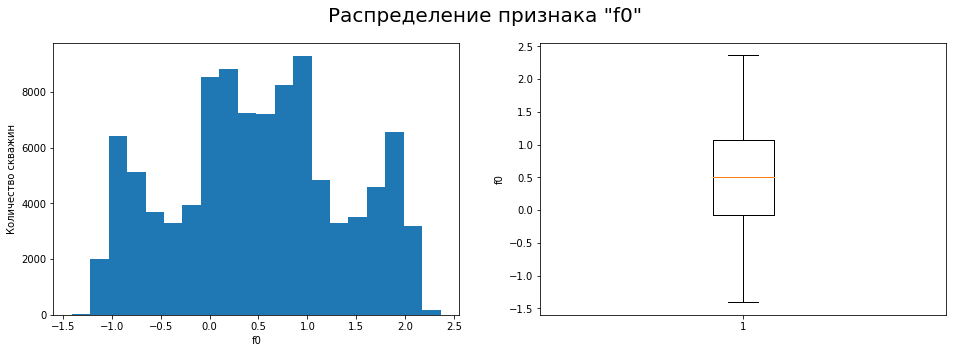

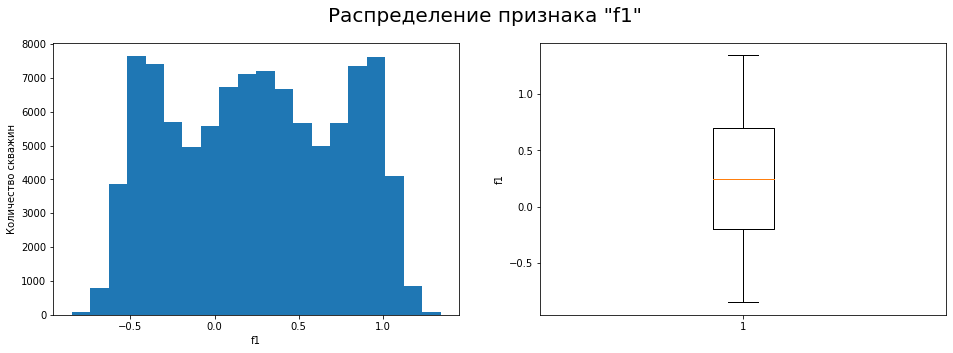

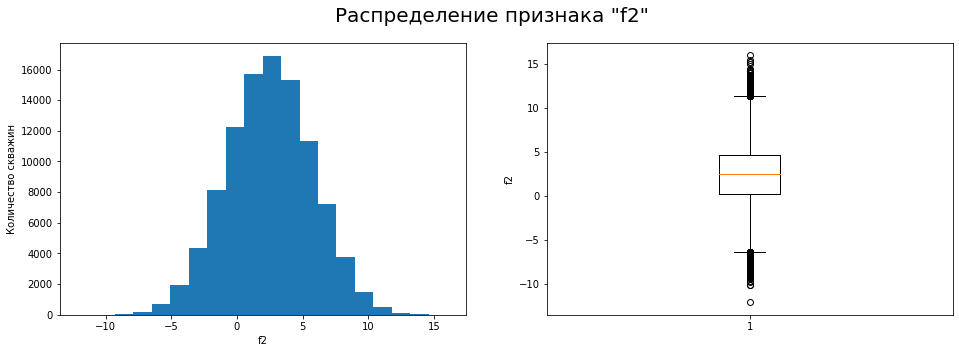

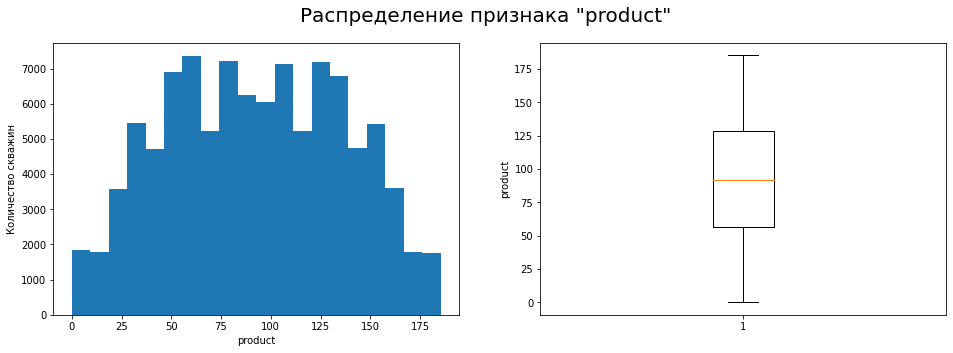

In [12]:
plot_dict = {'f0': 20, 'f1': 20, 'f2': 20, 'product': 20}
for key, value in plot_dict.items():
    build_hist_boxplot(data_0, key, value, 'Количество скважин')

На графиках выше представлено распределение характеристик скважин в первом регионе.

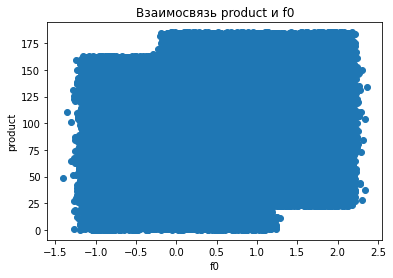

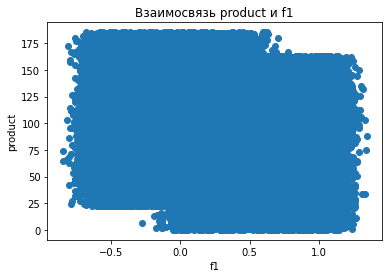

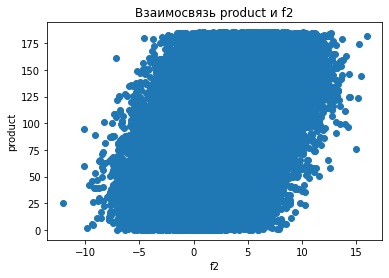

In [13]:
for item in ['f0', 'f1', 'f2']:
    scatter_plt(data_0, item)

По графикам зависимости целевой переменной от признаков f0 и f1 видно, что их можно попробовать заменить на категориальные значения, поделив значения признаков на 3 части. Между pruduct и f2 видна прямая линейная взаимосвязь.

In [14]:
data_0.loc[data_0['product'] > 175, 'f0'].min()

-0.2071704319986845

In [15]:
data_0.loc[data_0['product'] < 10, 'f0'].max()

1.2404206665885005

In [16]:
def cat_f0(x):
    if x < -0.2071704319986845:
        return 1
    elif x <= 1.2404206665885005:
        return 2
    else:
        return 3

In [17]:
data_0_copy = data_0.copy()

In [18]:
data_0_copy['f0_modify'] = data_0_copy['f0'].apply(cat_f0)

In [19]:
data_0.loc[(data_0['f1'] > -0.27) & (data_0['product'] < 10), 'f1'].min()

-0.1777123685567564

In [20]:
data_0.loc[data_0['product'] > 175, 'f1'].max()

0.7028315323864278

In [21]:
def cat_f1(x):
    if x < -0.1777123685567564:
        return 1
    elif x <= 0.7028315323864278:
        return 2
    else:
        return 3

In [22]:
data_0_copy['f1_modify'] = data_0_copy['f1'].apply(cat_f1)

In [23]:
data_0_copy = data_0_copy.drop(['f0', 'f1'], axis=1)

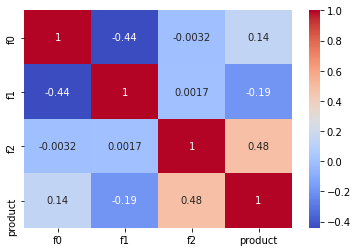

In [24]:
sns.heatmap(data_0.corr(), annot = True, cmap= 'coolwarm')
plt.show()

Наиболее сильная корреляция целевого признака product c f2. Мультиколлинеарности в данных нет.

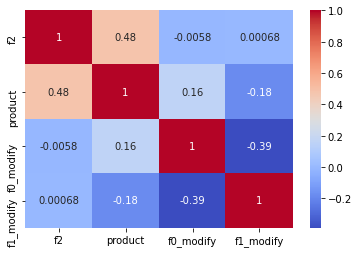

In [25]:
sns.heatmap(data_0_copy.corr(), annot = True, cmap= 'coolwarm')
plt.show()

По таблице корреляции добавленные признаки также не имеют сильной связи с целевым.

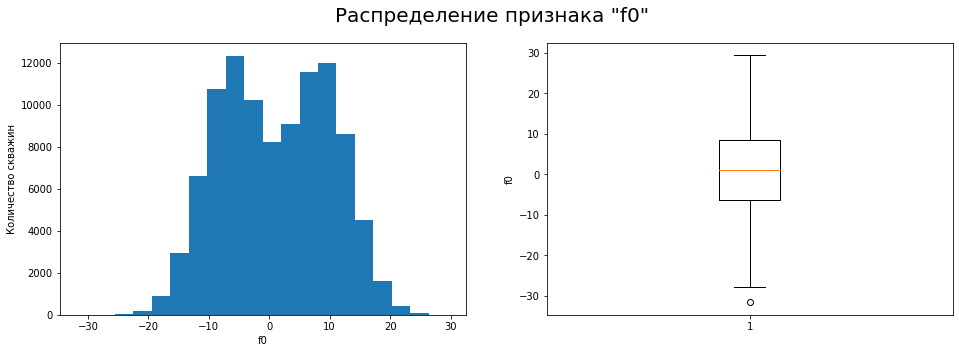

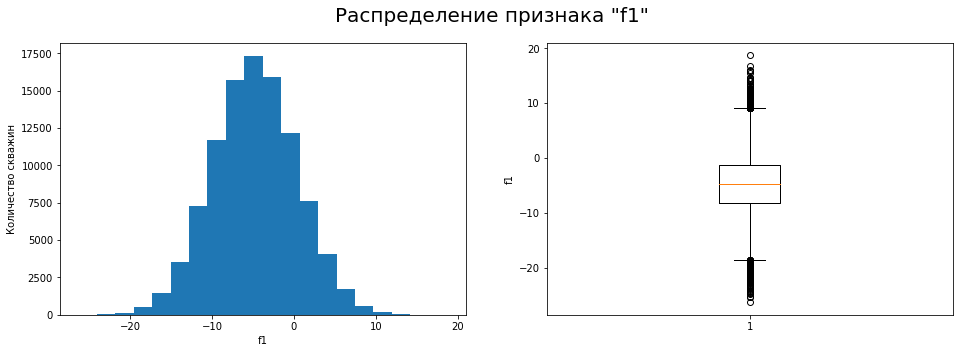

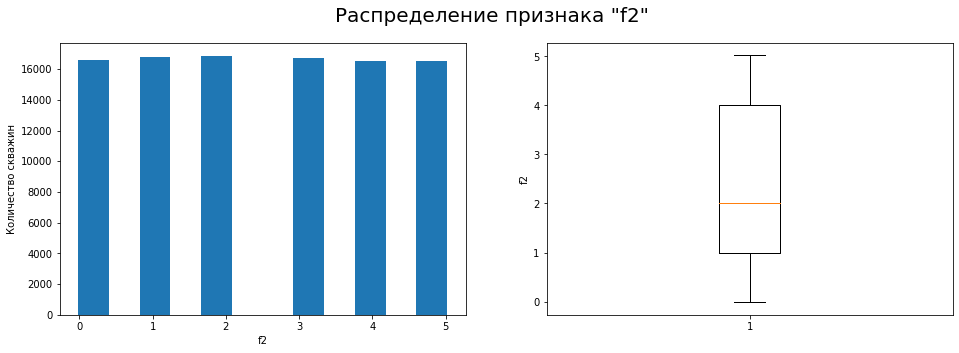

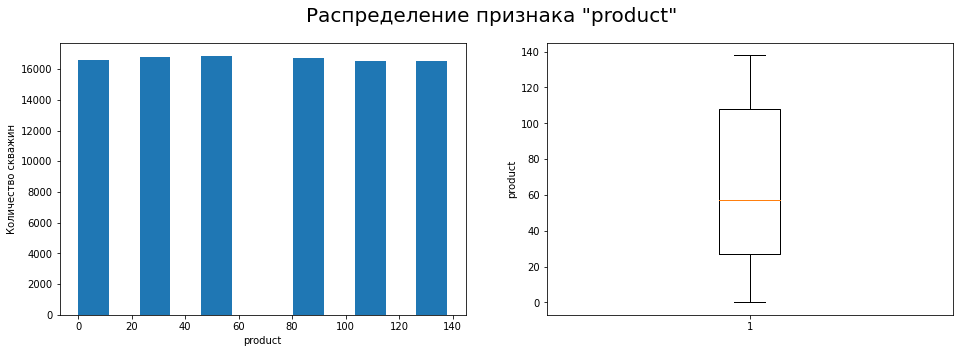

In [26]:
plot_dict = {'f0': 20, 'f1': 20, 'f2': 12, 'product': 12}
for key, value in plot_dict.items():
    build_hist_boxplot(data_1, key, value, 'Количество скважин')

In [27]:
len(data_1['f2'].unique())

100000

In [28]:
len(data_1['product'].unique())

12

На графиках выше представлено распределение характеристик скважин во втором регионе. Распределения признаков f2 и product выглядят как дискретные. f2 содержит 10000 различных значений, равномерно сгруппированных вокруг цифр от 0 до 5. product содержит 12 различных значений, попарно близких друг другу. Можно предположить, что при оценке данных параметров во втором регионе на оборудование были наложены какие-то ограничения, либо оборудование неисправно.

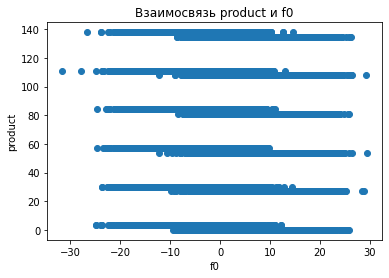

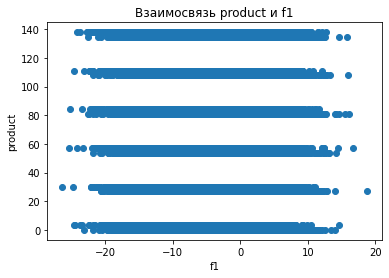

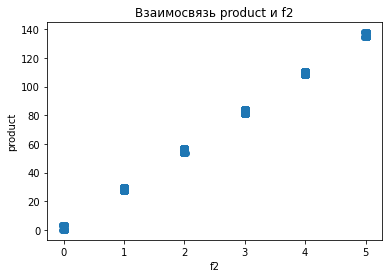

In [29]:
for item in ['f0', 'f1', 'f2']:
    scatter_plt(data_1, item)

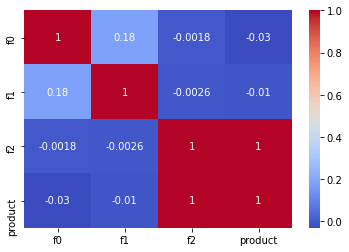

In [30]:
sns.heatmap(data_1.corr(), annot = True, cmap= 'coolwarm')
plt.show()

Целевой признак имеет очень сильную корреляцию с характеристикой f2, близкую к 100%.

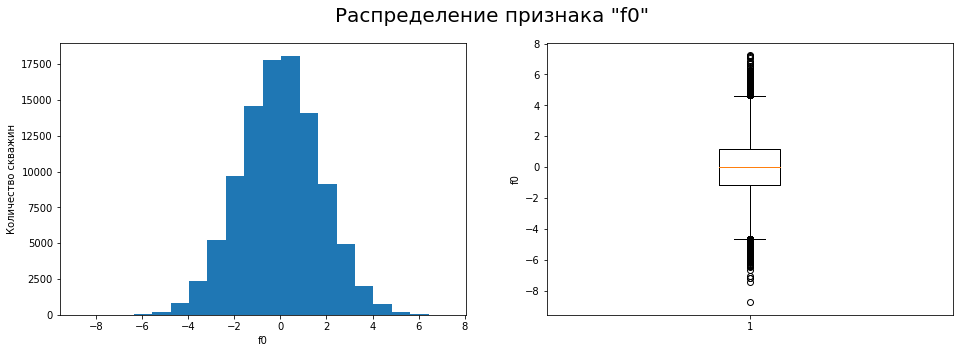

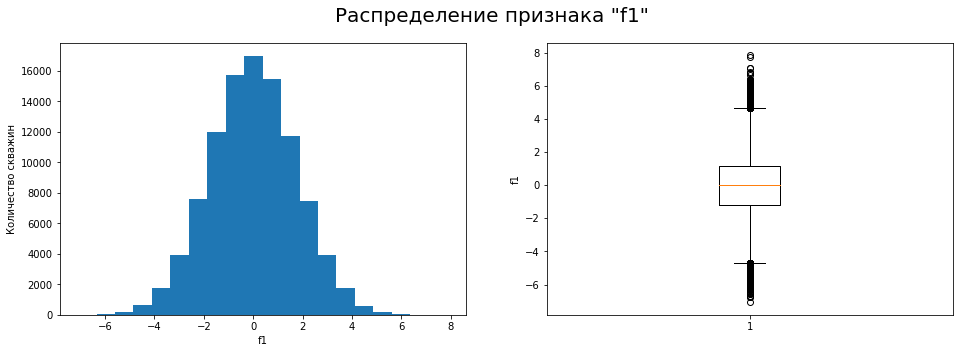

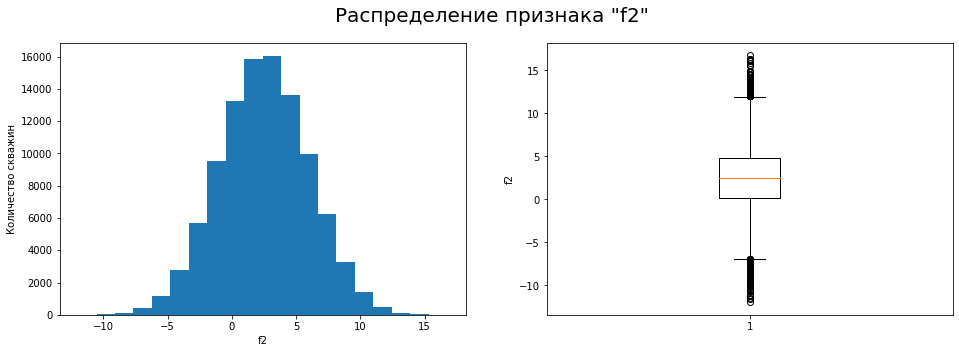

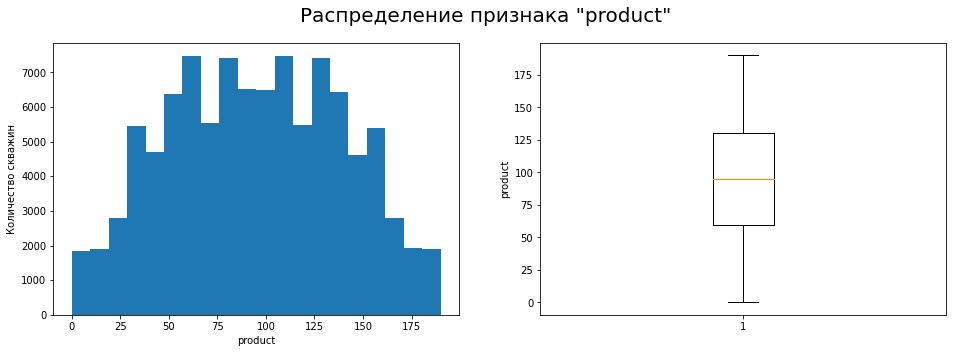

In [31]:
plot_dict = {'f0': 20, 'f1': 20, 'f2': 20, 'product': 20}
for key, value in plot_dict.items():
    build_hist_boxplot(data_2, key, value, 'Количество скважин')

На графиках выше представлено распределение характеристик скважин в третьем регионе.

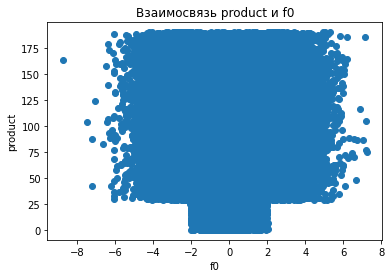

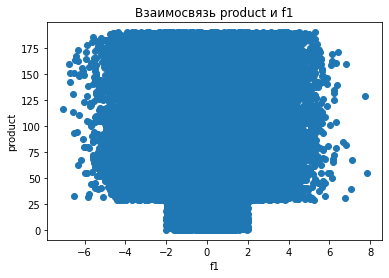

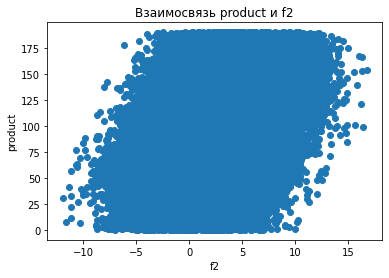

In [32]:
for item in ['f0', 'f1', 'f2']:
    scatter_plt(data_2, item)

Между pruduct и f2 видна прямая линейная взаимосвязь. По графикам зависимости целевой переменной от признаков f0 и f1 видно, что их можно попробовать заменить на категориальные значения, поделив значения признаков на 3 части.

In [33]:
data_2.loc[data_2['product'] < 20, 'f0'].min()

-2.0264306178936167

In [34]:
data_2.loc[data_2['product'] < 20, 'f0'].max()

2.021155524162423

In [35]:
def cat_f0(x):
    if -2.0264306178936167 <= x <= 2.021155524162423:
        return 1
    else:
        return 2

In [36]:
data_2_copy = data_2.copy()

In [37]:
data_2_copy['f0_modify'] = data_2_copy['f0'].apply(cat_f0)

In [38]:
data_2.loc[data_2['product'] < 20, 'f1'].min()

-2.033720669711301

In [39]:
data_2.loc[data_2['product'] < 20, 'f1'].max()

2.0223364555295733

In [40]:
def cat_f1(x):
    if -2.033720669711301 <= x <= 2.0223364555295733:
        return 1
    else:
        return 2

In [41]:
data_2_copy['f1_modify'] = data_2_copy['f1'].apply(cat_f0)

In [42]:
data_2_copy = data_2_copy.drop(['f0', 'f1'], axis=1)

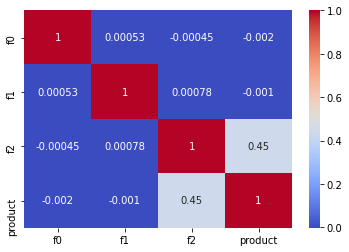

In [43]:
sns.heatmap(data_2.corr(), annot = True, cmap= 'coolwarm')
plt.show()

Наиболее сильная корреляция целевого признака product c f2. Мультиколлинеарности в данных нет.

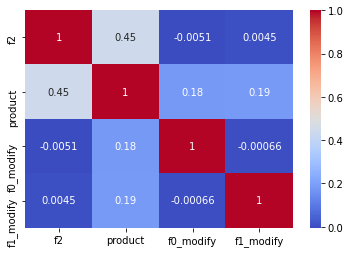

In [44]:
sns.heatmap(data_2_copy.corr(), annot = True, cmap= 'coolwarm')
plt.show()

Корреляция измененных признаков f0 и f1 c целевым выше, чем у исходных. 

In [45]:
ydata_profiling.ProfileReport(data_0)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Обучение и проверка модели

Выполним подготовку данных к обучению модели. Данные разбиваем на тренировочную и валидационную выборки в отношении 75:25. При помощи RandomizedSearchCV подберем лучшие гиперпараметры для обучения:
- для категориальных признаков: OneHotEncoder или OrdinalEncoder;
- для количественных признаков масштабирование с помощью StandardScaler, MinMaxScaler, RobustScaler или отсутствие масштабирования. 

In [46]:
def train_model(data, num_columns, ohe_columns):
    
    X_train, X_valid, y_train, y_valid = train_test_split(data.drop('product', axis=1), data['product'], random_state=0)
    
    data_preprocessor = ColumnTransformer(
        [('ohe', OneHotEncoder(), ohe_columns),
         ('num', MinMaxScaler(), num_columns)
        ], 
        remainder='passthrough'
    )

    pipe = Pipeline([
        ('preprocessor', data_preprocessor),
        ('model', LinearRegression())
    ])

    param_grid = [
        {
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'], 
            'preprocessor__ohe': [OneHotEncoder(drop='first', handle_unknown='ignore'), OrdinalEncoder(), StandardScaler()]
        }
    ]

    grid_search = GridSearchCV(
        pipe, 
        param_grid, 
        cv=KFold(5, shuffle=True, random_state=0),
        scoring='neg_root_mean_squared_error',
        n_jobs=1
    )

    grid_search.fit(X_train, y_train)

    print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
    print()
    print ('Метрика лучшей модели на кросс-валидации:', -1 * grid_search.best_score_)
    names = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
    print()
    print('Оценка важности признаков для модели:')
    print(pd.Series(grid_search.best_estimator_['model'].coef_, index=names))
    
    return grid_search.best_estimator_, X_train, y_train, X_valid, y_valid

In [47]:
def analize_model(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    print('RMSE :', mean_squared_error(y_valid, y_pred, squared=False))
    print('Средний запас предсказанного сырья:', y_pred.mean())
    return y_pred

In [48]:
def analize_difference(y_test, predictions):
    residuals = y_test - predictions

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    axes[0].hist(residuals)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')
    axes[0].set_ylabel('Количество записей')

    axes[1].scatter(predictions, residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.subplots_adjust(wspace=0.3)
    plt.show()

In [49]:
model_r0, X_train_r0, y_train_r0, X_valid_r0, y_valid_r0 = train_model(data_0, ['f0', 'f1', 'f2'], [])

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  []),
                                                 ('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', LinearRegression())])

Метрика лучшей модели на кросс-валидации: 37.76365295346038

Оценка важности признаков для модели:
num__f0     3.228745
num__f1    -7.057941
num__f2    21.421866
dtype: float64


In [50]:
(model_r0_with_cat, X_train_r0_with_cat, y_train_r0_with_cat, 
X_valid_r0_with_cat, y_valid_r0_with_cat) = train_model(data_0_copy, ['f2'], ['f0_modify', 'f1_modify'])

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OrdinalEncoder(),
                                                  ['f0_modify', 'f1_modify']),
                                                 ('num', StandardScaler(),
                                                  ['f2'])])),
                ('model', LinearRegression())])

Метрика лучшей модели на кросс-валидации: 37.73088960194656

Оценка важности признаков для модели:
ohe__f0_modify     7.667303
ohe__f1_modify    -8.239863
num__f2           21.420977
dtype: float64


Модель для первого региона, которая обучалась на измененных признаках f0 и f1, имеет более низкую оценку RMSE, а значит работает точнее. Также модифицированным признакам присвоена более высокая важность, чем в первоначальном варианте. Для дальнейших предсказаний будем использовать данную модель.

In [51]:
y_pred_r0 = analize_model(model_r0_with_cat, X_train_r0_with_cat, y_train_r0_with_cat, X_valid_r0_with_cat, y_valid_r0_with_cat)

RMSE : 37.46009008966195
Средний запас предсказанного сырья: 92.24842722649302


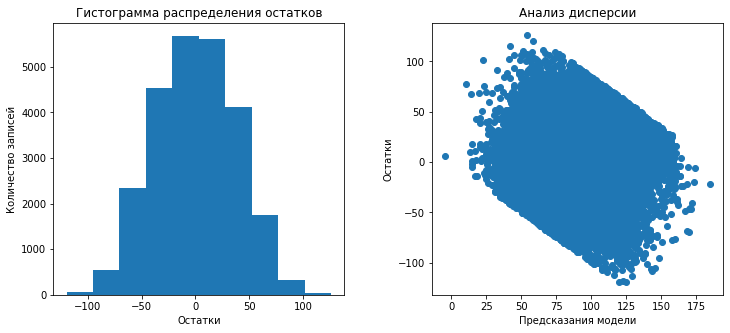

In [52]:
analize_difference(y_valid_r0_with_cat, y_pred_r0)

Гистограмма распределения остатков близка к нормальному распределению с центром в 0. На предельных значениях предсказаний разброс ошибок ниже. 

In [53]:
model_r1, X_train_r1, y_train_r1, X_valid_r1, y_valid_r1 = train_model(data_1, ['f0', 'f1', 'f2'], [])

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  []),
                                                 ('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', LinearRegression())])

Метрика лучшей модели на кросс-валидации: 0.8914671035257552

Оценка важности признаков для модели:
num__f0    -1.299182
num__f1    -0.108735
num__f2    45.910094
dtype: float64


Модель для второго региона имеет оценку RMSE 0.89, что говорит о высокой точности предсказаний. Характеристика f2 имеет большой вес, что обуславливается ее высокой корреляцией с целевой переменной.

In [54]:
y_pred_r1= analize_model(model_r1, X_train_r1, y_train_r1, X_valid_r1, y_valid_r1)

RMSE : 0.8872573052219329
Средний запас предсказанного сырья: 69.15162398290754


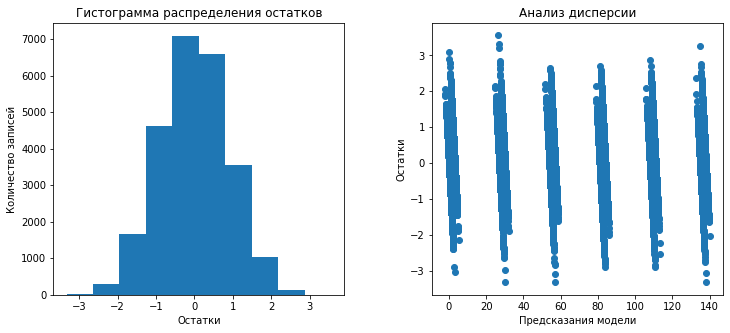

In [55]:
analize_difference(y_valid_r1, y_pred_r1)

Отклонения в предсказаниях модели составляют не более трех единиц.

In [56]:
model_r2, X_train_r2, y_train_r2, X_valid_r2, y_valid_r2 = train_model(data_2, ['f0', 'f1', 'f2'], [])

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  []),
                                                 ('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', LinearRegression())])

Метрика лучшей модели на кросс-валидации: 39.971070040240434

Оценка важности признаков для модели:
num__f0     0.071499
num__f1    -0.033562
num__f2    19.998250
dtype: float64


In [57]:
(model_r2_with_cat, X_train_r2_with_cat, y_train_r2_with_cat, 
 X_valid_r2_with_cat, y_valid_r2_with_cat) = train_model(data_2_copy, ['f2'], ['f0_modify', 'f1_modify'])

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['f0_modify', 'f1_modify']),
                                                 ('num', StandardScaler(),
                                                  ['f2'])])),
                ('model', LinearRegression())])

Метрика лучшей модели на кросс-валидации: 38.26200839892081

Оценка важности признаков для модели:
ohe__f0_modify_2    19.252478
ohe__f1_modify_2    18.958557
num__f2             20.006381
dtype: float64


При использовании категориальных признаков f0 и f1 видно улучшение оценки RMSE, также данные признаки имеют важность, близкую к признаку f2. Для получения предсказаний будем использовать модель с категориальными f0 и f1. 

In [58]:
y_pred_r2 = analize_model(model_r2_with_cat, X_train_r2_with_cat, y_train_r2_with_cat, X_valid_r2_with_cat, y_valid_r2_with_cat)

RMSE : 38.57370459335464
Средний запас предсказанного сырья: 94.82682421617042


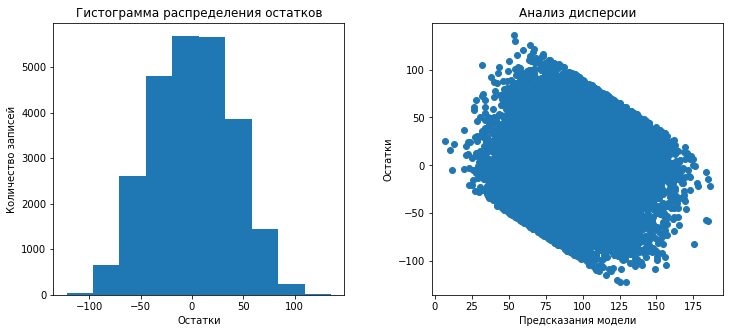

In [59]:
analize_difference(y_valid_r2_with_cat, y_pred_r2)

Распределение остатков для третьего региона похоже на распределение остатков для первого. 

Модели для первого и третьего регионов дают похожие предсказания (RMSE = 37.46, средний запас предсказанного сырья 92.25 и RMSE = 38.57, средний запас предсказанного сырья 94.8 соответственного). Результаты для второго региона RMSE = 0.89, средний запас предсказанного сырья 69.15 сильно отличаются. Возможно, что регионы 0 и 2 близки по характеристикам и для их оценки оспользовали схожее оборудование. Также стоит заметить большое значение RMSE для данных регионов, составляющее около 40% от среднего запаса сырья.

## Подготовка к расчёту прибыли

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки. Бюджет на разработку скважин в регионе — 10 млрд рублей. Доход с каждой единицы продукта составляет 450 тыс. рублей.

In [60]:
BUDGET = 1_000_000_0000

In [61]:
COUNT_RESEARCH = 500

In [62]:
COUNT_CHOOSE = 200

In [63]:
BARREL_PRICE = 450000

In [64]:
BUDGET / COUNT_CHOOSE / BARREL_PRICE

111.11111111111111

Для безубыточной разработки новой скважины необходим средний объем в каждой около 111 тыс. баррелей. Все предсказанные средние запасы для регионов меньше этой цифры.

## Расчёт прибыли и рисков 

In [65]:
def helping(y_pred, X_valid):
    X_valid['pred'] = y_pred
    y_pred = X_valid['pred']
    return y_pred


In [66]:
def revenue(y_valid, y_pred, count):
    pred_sorted = y_pred.sort_values(ascending=False)
    selected = y_valid[pred_sorted.index][:count]
    return selected.sum() * BARREL_PRICE - BUDGET

In [67]:
for item in [[y_valid_r0_with_cat, helping(y_pred_r0, X_valid_r0_with_cat), 'первого'],
            [y_valid_r1, helping(y_pred_r1, X_valid_r1), 'второго'],
            [y_valid_r2_with_cat, helping(y_pred_r2, X_valid_r2_with_cat), 'третьего']]:
    inc = revenue(item[0], item[1], COUNT_CHOOSE)
    print(f'Прибыль для {item[2]} региона {inc/1000000:.2f} млн. рублей')

Прибыль для первого региона 3258.73 млн. рублей
Прибыль для второго региона 2415.09 млн. рублей
Прибыль для третьего региона 3438.82 млн. рублей


In [68]:
def bootstrap(y_valid, y_pred, X_valid):
    y_pred = helping(y_pred, X_valid)
    state = np.random.RandomState(12345)
    values = []
    
    for i in range(1000):
        target_subsample = y_valid.sample(n=COUNT_RESEARCH, replace=True, random_state=state)
        pred_subsample = y_pred[target_subsample.index]
        values.append(revenue(target_subsample, pred_subsample, COUNT_CHOOSE))
    
    values = pd.Series(values)
    mean_income = values.mean()
    confidence_interval = st.t.interval(0.95, len(values) - 1, values.mean(), values.sem())
    probability_of_losses = (values < 0).mean() * 100
        
    return mean_income, confidence_interval, probability_of_losses, values

In [69]:
for item in [[y_valid_r0_with_cat, y_pred_r0, X_valid_r0_with_cat, 'первого'],
             [y_valid_r1, y_pred_r1, X_valid_r1, 'второго'],
             [y_valid_r2_with_cat, y_pred_r2, X_valid_r2_with_cat, 'третьего']]:
    mean_income, confidence_interval, probability_of_losses, v = bootstrap(item[0], item[1], item[2])
    print(f'Средняя прибыть {item[3]} региона {mean_income/1000000:.2f} млн. рублей')
    print(f'Доверительный интервал для средней прибыли {item[3]} региона {confidence_interval[0]/1000000:.2f} - {confidence_interval[1]/1000000:.2f} млн. рублей')
    print(f'Доверительный интервал для {item[3]} региона {v.quantile(0.025)/1000000:.2f} - {v.quantile(0.975)/1000000:.2f} млн. рублей')
    print(f'Риск убытков для {item[3]} региона {probability_of_losses:.1f}%')
    if probability_of_losses > 2.5:
        print('Большая вероятность убытков')
    else:
        print('Вероятность убытков менее 2.5%')
    print()

Средняя прибыть первого региона 486.37 млн. рублей
Доверительный интервал для средней прибыли первого региона 469.17 - 503.57 млн. рублей
Доверительный интервал для первого региона -73.62 - 1000.28 млн. рублей
Риск убытков для первого региона 4.6%
Большая вероятность убытков

Средняя прибыть второго региона 536.39 млн. рублей
Доверительный интервал для средней прибыли второго региона 523.27 - 549.50 млн. рублей
Доверительный интервал для второго региона 115.11 - 970.74 млн. рублей
Риск убытков для второго региона 0.6%
Вероятность убытков менее 2.5%

Средняя прибыть третьего региона 699.38 млн. рублей
Доверительный интервал для средней прибыли третьего региона 682.23 - 716.53 млн. рублей
Доверительный интервал для третьего региона 194.06 - 1215.59 млн. рублей
Риск убытков для третьего региона 0.9%
Вероятность убытков менее 2.5%



Оценка рисков показала, что в первом регионе большая вероятность убытков (4.6%), поэтому данный регион не подходит для разработки месторождений. Средняя прибыль для третьего региона заметно больше, чем для второго, поэтому выбираем данный регион для бурения скважины.

## Выводы

Была проведена работа с информацией о скважинах в трех разных регионах. С помощью модели МО были выполнены предсказания, после чего проведен анализ, в ходе которого выбран лучший регион для разработки новых месторождений.

В проекте использованы 3 датафрейма, каждый из которых содержит 3 характеристики и объем запасов в скважинах для каждого из регионов. Пропуски и дубликаты в данных отсутствуют.

Проведен исследовательский анализ данных:
- Для первого региона:
    - между pruduct и f2 существует прямая линейная взаимосвязь;
    - принято решение заменить признаки f0 и f1 на категориальные значения; 
    - на графике корреляции наиболее сильная связь целевого признака c f2.
- Для второго региона:
    - распределения признаков f2 и product выглядят как дискретные. Можно предположить, что при оценке данных параметров во втором регионе на оборудование были наложены какие-то ограничения, либо оборудование неисправно;
    - целевой признак имеет очень сильную корреляцию с характеристикой f2, близкую к 100%.
- Для третьего региона:
     - между pruduct и f2 существует прямая линейная взаимосвязь; 
     - после преобразования признаков f0 и f1 увеличилась их корреляция с product;
     - наиболее сильная корреляция целевого признака c f2.

Выполнена подготовку данных к обучению модели. Данные были разбиты на тренировочную и валидационную выборки в отношении 75:25. При помощи RandomizedSearchCV подбирались лучшие гиперпараметры для обучения из списка:
- для категориальных признаков: OneHotEncoder или OrdinalEncoder;
- для количественных признаков масштабирование с помощью StandardScaler, MinMaxScaler, RobustScaler или отсутствие масштабирования. 

Модели для первого и третьего регионов были обучены с помощью 1 количественного и 2 категориальных признаков, модель для второго региона полностью на количественных. Наиболее точной получилась модель для второго региона.
Результаты предсказаний моделей:
- для первого региона: RMSE - 37.46, средний запас предсказанного сырья - 92.25;
- для второго региона: RMSE - 0.89, средний запас предсказанного сырья - 69.15;
- для третьего региона: RMSE - 38.57, средний запас предсказанного сырья - 94.83.

Для безубыточной разработки новой скважины необходим средний объем в каждой около 111 тыс. баррелей. Все предсказанные средние запасы для регионов оказались меньше этой цифры.

Были выбраны скважины с максимальными значениями предсказаний. Затем просуммировано целевое значение объёма сырья, соответствующее этим предсказаниям и рассчитана прибыли для полученного объема. Результаты:
- прибыль для первого региона 3258.73 млн. рублей;
- прибыль для второго региона 2415.09 млн. рублей;
- прибыль для третьего региона 3438.82 млн. рублей.

После чего была применена техника Bootstrap с 1000 выборок, чтобы найти распределение прибыли для оценки средней прибыли и риска убытков:
- средняя прибыть первого региона 486.37 млн. рублей, риск убытков 4.6%
- средняя прибыть второго региона 536.39 млн. рублей, риск убытков 0.6%
- средняя прибыть третьего региона 699.38 млн. рублей, риск убытков 0.9%

Согласно условиям задачи необходимо оставить только те регионы, в которых риск убытков менее 2.5% и среди них выбрать регион с наибольшей средней прибылью. Риск убытков менее 2.5% во втором и третьем регионе, при этом средняя прибыль для третьего региона выше. Также можно поставить под сомнения данные по второму региону из-за возможной неисправности оборудования. Для бурения новых скважин рекомендуется третий регион. 